In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
documents = pd.read_csv('../data/preprocessed.csv', index_col=None, converters={'lemmas': eval, 'stemmas': eval})

In [3]:
documents.head()

review sentiment  \
0  One of the other reviewers has mentioned that ...  positive   
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
3  Basically there's a family where a little boy ...  negative   
4  Petter Mattei's "Love in the Time of Money" is...  positive   

                                              lemmas  \
0  [reviewer, mention, watch, 1, oz, episode, ll,...   
1  [wonderful, little, production, filming, techn...   
2  [think, wonderful, way, spend, time, hot, summ...   
3  [basically, s, family, little, boy, jake, thin...   
4  [petter, matteis, love, time, money, visually,...   

                                             stemmas  
0  [review, mention, watch, 1, oz, episod, ll, ho...  
1  [wonder, littl, product, film, techniqu, unass...  
2  [think, wonder, way, spend, time, hot, summer,...  
3  [basic, s, famili, littl, boy, jake, think, s,...  
4  [petter, mattei, love, time, money, visual, st...

### Label coding

In [4]:
category_codes = {
    'positive': 1,
    'negative': 0,
}


documents['sentiment_code'] = documents['sentiment']
documents = documents.replace({'sentiment_code':category_codes})

In [5]:
documents.head()

review sentiment  \
0  One of the other reviewers has mentioned that ...  positive   
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
3  Basically there's a family where a little boy ...  negative   
4  Petter Mattei's "Love in the Time of Money" is...  positive   

                                              lemmas  \
0  [reviewer, mention, watch, 1, oz, episode, ll,...   
1  [wonderful, little, production, filming, techn...   
2  [think, wonderful, way, spend, time, hot, summ...   
3  [basically, s, family, little, boy, jake, thin...   
4  [petter, matteis, love, time, money, visually,...   

                                             stemmas  sentiment_code  
0  [review, mention, watch, 1, oz, episod, ll, ho...               1  
1  [wonder, littl, product, film, techniqu, unass...               1  
2  [think, wonder, way, spend, time, hot, summer,...               1  
3  [basic, s, famili, littl, boy, jake, think, s,...               0  
4  [petter, mattei, love, time, money, visual, st...               1

### Text representation

TF-IDF is a score that represents the relative importance of a term in the document and the entire corpus. TF stands for Term Frequency, and IDF stands for Inverse Document Frequency:

\begin{equation}
\textit{TFIDF} = \textit{TF(t,d)} x log(\textit{N/DF(t)})
\end{equation}

In [6]:
train, test = documents[int(len(documents) * 85/100):], documents[:int(len(documents) * 85/100)]



In [7]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(train['lemmas'].str.join(' '))


X = tfidf_vectorizer.transform(train['lemmas'].str.join(' '))
X_test = tfidf_vectorizer.transform(test['lemmas'].str.join(' '))
target = train['sentiment_code']
y_test = test['sentiment_code']

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)



In [8]:
from sklearn.linear_model import LogisticRegression


In [9]:
best_c = None
best_score = 0

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    score = accuracy_score(y_val, lr.predict(X_val))
    print ("Accuracy for C=%s: %s" % (c, score))
    if score > best_score:
        best_score = score
        best_c = c
    

    
final_wc = LogisticRegression(C=best_c)
final_wc.fit(X, target)
print ("Final Accuracy (C=%s): %s" 
       % (best_c, accuracy_score(y_test, final_wc.predict(X_test))))


Accuracy for C=0.01: 0.712
Accuracy for C=0.05: 0.7973333333333333
Accuracy for C=0.25: 0.8384
Accuracy for C=0.5: 0.8501333333333333
Accuracy for C=1: 0.8576
Final Accuracy (C=1): 0.861764705882353


In [10]:
from sklearn.svm import LinearSVC


for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    score = accuracy_score(y_val, svm.predict(X_val))
    print ("Accuracy for C=%s: %s" % (c, score))
    if score > best_score:
        best_score = score
        best_c = c

    
final_svm_ngram = LinearSVC(C=best_c)
final_svm_ngram.fit(X, target)
print ("Final Accuracy (C=%s): %s" 
       % (best_c, accuracy_score(y_test, final_svm_ngram.predict(X_test))))

Accuracy for C=0.01: 0.8138666666666666
Accuracy for C=0.05: 0.8458666666666667
Accuracy for C=0.25: 0.8597333333333333
Accuracy for C=0.5: 0.8581333333333333
Accuracy for C=1: 0.8549333333333333
Final Accuracy (C=0.25): 0.8686117647058823


In [11]:
feature_to_coef = {
    word: coef for word, coef in zip(
        tfidf_vectorizer.get_feature_names(), final_svm_ngram.coef_[0]
    )
}

for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:30]:
    print (best_positive)
    
print("\n\n")
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:30]:
    print (best_negative)

('great', 2.6857180901068607)
('excellent', 2.07818438350029)
('love', 1.6163013906455836)
('good', 1.5728670268906966)
('amazing', 1.492810009665494)
('wonderful', 1.3952501263849753)
('perfect', 1.390132460812214)
('fantastic', 1.3869608127773871)
('enjoy', 1.3551903811935067)
('fun', 1.3430439366452647)
('favorite', 1.3176502601765456)
('today', 1.2910382829019247)
('show', 1.192484179650051)
('highly', 1.1792042277854036)
('strong', 1.1742154391622737)
('brilliant', 1.155771399693076)
('hilarious', 1.1321987737969723)
('definitely', 1.0901501342542605)
('recommend', 1.0555450377761249)
('enjoyable', 1.045619340300643)
('entertaining', 1.0006330013246645)
('solid', 0.9895357019866023)
('world', 0.9846315220031945)
('classic', 0.9832090539170679)
('710', 0.9806012721523901)
('performance', 0.9803639786958418)
('different', 0.9800801856965327)
('bit', 0.9401031203543672)
('awesome', 0.9382882941550512)
('thank', 0.9260854415813036)



('bad', -3.8458720247283353)
('waste', -2.65075256

In [12]:
svc_report=classification_report(y_test,final_wc.predict(X_test),target_names=['Positive','Negative'])
print(svc_report)

              precision    recall  f1-score   support

    Positive       0.88      0.84      0.86     21263
    Negative       0.84      0.89      0.87     21237

    accuracy                           0.86     42500
   macro avg       0.86      0.86      0.86     42500
weighted avg       0.86      0.86      0.86     42500



In [13]:
svm_report=classification_report(y_test,final_svm_ngram.predict(X_test),target_names=['Positive','Negative'])
print(svm_report)

              precision    recall  f1-score   support

    Positive       0.89      0.85      0.87     21263
    Negative       0.85      0.89      0.87     21237

    accuracy                           0.87     42500
   macro avg       0.87      0.87      0.87     42500
weighted avg       0.87      0.87      0.87     42500



In [14]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
predictions = naive_bayes.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))

Accuracy score:  0.8435058823529412
Precision score:  0.8309584316572881
Recall score:  0.8622215943871545


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit


# Create t he parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1,
                           n_jobs=10)

# Fit the grid search to the data
grid_search.fit(X, target)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=RandomForestClassifier(random_state=8), n_jobs=10,
             param_grid={'bootstrap': [False], 'max_depth': [30, 40, 50],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [800]},
             scoring='accuracy', verbose=1)

In [17]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 800}

The mean accuracy of a model with these hyperparameters is:
0.8480808080808081


In [18]:
best_rfc = grid_search.best_estimator_
best_rfc.fit(X, target)


rfc_pred = best_rfc.predict(X_test)


# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(target, best_rfc.predict(X)))

# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, rfc_pred))

# Classification report
print("Classification report")
print(classification_report(y_test,rfc_pred))

The training accuracy is: 
0.9956
The test accuracy is: 
0.847764705882353
Classification report
              precision    recall  f1-score   support

           0       0.86      0.83      0.85     21263
           1       0.84      0.86      0.85     21237

    accuracy                           0.85     42500
   macro avg       0.85      0.85      0.85     42500
weighted avg       0.85      0.85      0.85     42500



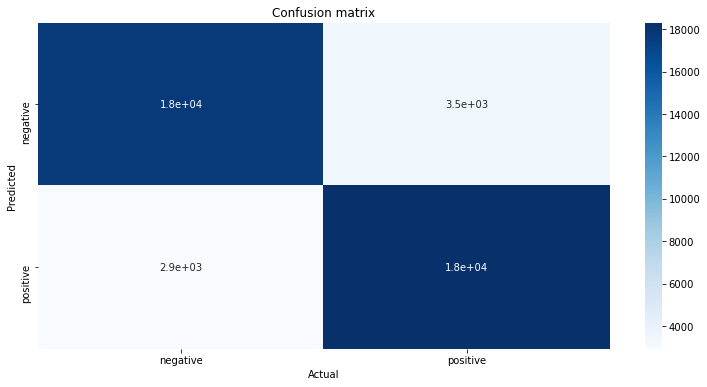

In [19]:
aux_df = documents[['sentiment', 'sentiment_code']].drop_duplicates().sort_values('sentiment_code')
conf_matrix = confusion_matrix(y_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['sentiment'].values, 
            yticklabels=aux_df['sentiment'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [20]:
from sklearn.neighbors import KNeighborsClassifier


# Create the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 500, num = 100)]

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X, target)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46,
                                         51, 56, 61, 66, 71, 76, 81, 86, 91, 96,
                                         101, 106, 111, 116, 121, 127, 132, 137,
                                         142, 147, ...]},
             scoring='accuracy', verbose=1)

In [21]:
best_knnc = grid_search.best_estimator_

In [22]:
best_knnc.fit(X, target)
knnc_pred = best_knnc.predict(X_test)


# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(target, best_knnc.predict(X)))

The training accuracy is: 
0.7906666666666666


In [23]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, knnc_pred))

# Classification report
print("Classification report")
print(classification_report(y_test,knnc_pred))

The test accuracy is: 
0.7780235294117647
Classification report
              precision    recall  f1-score   support

           0       0.74      0.86      0.79     21263
           1       0.83      0.70      0.76     21237

    accuracy                           0.78     42500
   macro avg       0.79      0.78      0.78     42500
weighted avg       0.79      0.78      0.78     42500

